### Fill in your name, student id number and email address
#### name: Juuso Pyykkönen
#### student id: 522060
#### email: jhpyyk@utu.fi

## Data analysis and knowledge discovery - Exercise 3: Unsupervised learning

his is the template for the third exercise. The purpose of this exercise is to familiarize yourself with the basics of unsupervised learning by using the agglomerative hierarchical clustering and k-means clustering algorithms to find patterns.

The data set utilised in this exercise is a simplified and downsampled version of a knowledge discovery and data mining competition data set. The data will be available on the course's Moodle page. For those who are interested, the original data can be found at https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html. However, please make sure to **use the version on Moodle** as `ex3_network_data.csv`. The data is described below.

The data set contains samples of network activity simulated in a military network environment. There are different types of malicious activity, and also activity that is considered normal. It is **not necessary** to understand the details of the data set in order to complete the exercise.

In addition to normal activity, there are 3 types of malicious activity - denial of service, unauthorized remote login, and network probing (e.g. port scanning) - simulated in a military network environment. There are 500 samples of each class. There are 6 numeric features, described below:

`src_bytes`: number of bytes from source to destination\
`dst_bytes`: number of bytes from destination to source\
`duration`: length of connection (seconds)\
`count`: number of connections to the same host as the current connection in the past two seconds\
`serror_rate`: percentage of connections that have SYN errors\
`rerror_rate`: percentage of connections that have REJ errors

In real applications, visualizing and cleaning the data are important steps. However, in this exercise you can treat the data as given, and focus on the unsupervised methods.

Please consider the following things when returning your notebook:

 - As in the two previous exercises, the grading scale is failed/passed/passed with honors.
 
 - For a passing grade each part of the exercise, except for the BONUS, must be completed, and all questions should be answered. Some mistakes are allowed as long as you clearly attempt to solve all the exercises.
 
 - For doing both the exercise and the optional bonus task sufficiently well, you will be awarded one bonus point for the exam.
 
 - All the cells in the finished notebook should run without crashing. Please delete unnecessary cells. As a good rule of thumb, use "Restart and run all" on the finished notebook to make sure it runs without errors and produces the expected output.

 - Remember to comment your code to explain how it works and what you intend for it to do.
 
 - Answer the questions asked in the assignments in Markdown cells.
 
 - If you are having problems with this exercise, try an online search first, but don't just copy-paste any code you find. See exercise guidelines in the Moodle page of this course. If you can't find a solution to your problem, ask for advice in the course discussion forum on Moodle or contact oskari.s.heikkinen@utu.fi.
 
 - If/when you look things up during this exercise, please cite your sources (e.g. a link to a web page). It's better to cite too much than too little.

### Library imports, Jupyter Notebook settings etc.

The below libraries are sufficient to complete the exercise. You can import additional functionality here if you want.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import linkage, dendrogram

%matplotlib inline

# Added Seaborn

import seaborn as sns

### Read the data

- Download the exercise 3 data on the Moodle page of this course.
- Read the data into a Pandas dataframe.
- Display a few rows and some basic information to make sure the data was loaded correctly

In [80]:
data = pd.read_csv('ex3_network_data.csv')
data

,src_bytes,dst_bytes,duration,count,serror_rate,rerror_rate,class
0,0,0,0,223,1.0,0.0,denial_of_service
1,1032,0,0,511,0.0,0.0,denial_of_service
2,520,0,0,511,0.0,0.0,denial_of_service
3,1032,0,0,510,0.0,0.0,denial_of_service
4,520,0,0,448,0.0,0.0,denial_of_service
...,...,...,...,...,...,...,...
1995,1229,2449,2,1,0.0,0.0,unauthorized_remote_login
1996,1232,2451,0,1,0.0,0.0,unauthorized_remote_login
1997,1242,2451,1,1,0.0,0.0,unauthorized_remote_login
1998,246,0,0,2,0.0,0.0,unauthorized_remote_login


In [81]:
data.describe()

,src_bytes,dst_bytes,duration,count,serror_rate,rerror_rate
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.00000
mean,402.324500,382.56600,20.246500,111.158000,0.059415,0.14014
std,464.815917,861.81793,241.867267,198.399713,0.234554,0.34661
min,0.000000,0.00000,0.000000,1.000000,0.000000,0.00000
25%,8.000000,0.00000,0.000000,1.000000,0.000000,0.00000
50%,286.500000,0.00000,0.000000,2.000000,0.000000,0.00000
75%,748.000000,146.00000,0.000000,105.250000,0.000000,0.00000
max,4703.000000,4982.00000,4776.000000,511.000000,1.000000,1.00000


### Part 1: Preprocess and visualize the data

 - Perform z-score standardization on the features to ensure that all features have the same scale.
 
 - Project the data to two dimensions by using principal component analysis (PCA) and visualize the resulting two-dimensional data in a scatter plot. Don't color the scatter plot yet.
 
 - Does it look like there are clear clusters? Don't worry if they're hard to see.

Because clustering is an unsupervised learning method, the `class` column is completely unnecessary for most of these tasks. You will only need the `class` column in **Part 4**, where it's used to compute a performance metric and to visually compare clustering results to the classes.

In [82]:
# check if src_bytes is categorical
data['src_bytes'].value_counts()

0       379
334     308
1032    308
8       203
18       76
       ... 
248       1
1625      1
212       1
554       1
1242      1
Name: src_bytes, Length: 303, dtype: int64

In [83]:
# Mark 'class' variable as categorical
data['class'] = data['class'].astype('category')

In [84]:
# Scale the data

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.select_dtypes('number'))

data_scaled

array([[-0.8657731 , -0.44401684, -0.08373007,  0.56386156,  4.01110523,
        -0.40441711],
       [ 1.35501594, -0.44401684, -0.08373007,  2.0158396 , -0.25337404,
        -0.40441711],
       [ 0.25322913, -0.44401684, -0.08373007,  2.0158396 , -0.25337404,
        -0.40441711],
       ...,
       [ 1.80692069,  2.40068259, -0.07959454, -0.55537152, -0.25337404,
        -0.40441711],
       [-0.33639897, -0.44401684, -0.08373007, -0.55032993, -0.25337404,
        -0.40441711],
       [-0.14702936, -0.44401684, -0.08373007, -0.55032993, -0.25337404,
        -0.40441711]])

Text(0, 0.5, 'PC2')

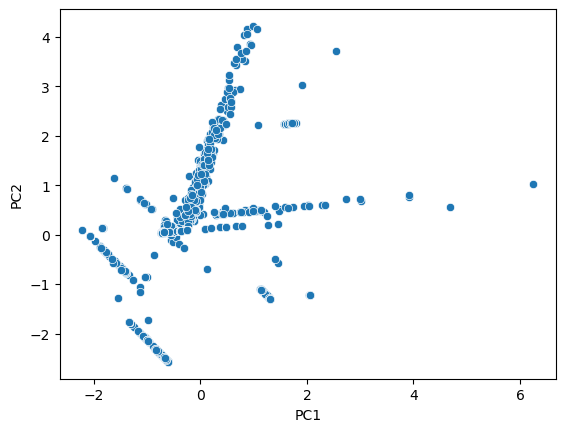

In [85]:
# Perform PCA and plot the result
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
pca_plot = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1])
pca_plot.set_xlabel('PC1')
pca_plot.set_ylabel('PC2')

There are two smaller clusters in the negative quadrant and a big cluster on a line from (0, 0) to (1.5, 4). There might be a cluster from (0, 0) to (6, 1).

### Part 2a: Agglomerative hierarchical clustering
 
 - Cluster the data into 4 clusters using agglomerative hierarchical clustering. Try different values for the "linkage" parameter.
 
 - Use the z-score standardized 6-dimensional data for clustering - not the principal components!
 
 - What is the significance of the linkage criterion in a hierarchical clustering algorithm?
 
 - Evaluate the clustering performance for each linkage criterion using a metric called "silhouette score".
 
 - What does silhouette score quantify and how is it computed?

In [86]:
# Cluster the data with different linkages

linkages = ['ward', 'complete', 'average', 'single']
clusterings = []

for link in linkages:
    clusterings.append(AgglomerativeClustering(n_clusters=4, linkage=link).fit(data_scaled))

The linkage criterion changes what is considered to be a cluster. From scikit-learn docs:

- *‘ward’ minimizes the variance of the clusters being merged.* 
- *‘average’ uses the average of the distances of each observation of the two sets.* 
- *‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.* 
- *‘single’ uses the minimum of the distances between all observations of the two sets.* 

In [87]:
for i, clustering in enumerate(clusterings):
    slht = silhouette_score(X=data_scaled, labels=clustering.labels_)
    print(linkages[i], ': ', slht)

ward :  0.6299185426647561
complete :  0.48157598037212385
average :  0.6241907400678147
single :  0.7288757664398099


From scikit-learn docs: *higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:*

- *a: The mean distance between a sample and all other points in the same class.*
- *b: The mean distance between a sample and all other points in the next nearest cluster.*

*The Silhouette Coefficient s for a single sample is then given as:*

$s = \frac{b - a}{max(a, b)}$

### Part 2b: Dendrograms

 - Plot dendrograms to visualize the merging processes.
 - For this you will need a linkage matrix. Hint: while you can extract one from a fitted AgglomerativeClustering object, it is much easier to use the scipy implementation (scipy.cluster.hierarchy.linkage).
 - Compute the linkage matrix using both `average` and `complete` linkage, and plot the dendrograms using scipy.cluster.hierarchy.dendrogram).
 - Truncate the dendrogram so that three levels of the dendrogram tree are visible for better readability.
 - How do you interpret the dendrograms? How do they differ?

Text(0.5, 1.0, 'Complete')

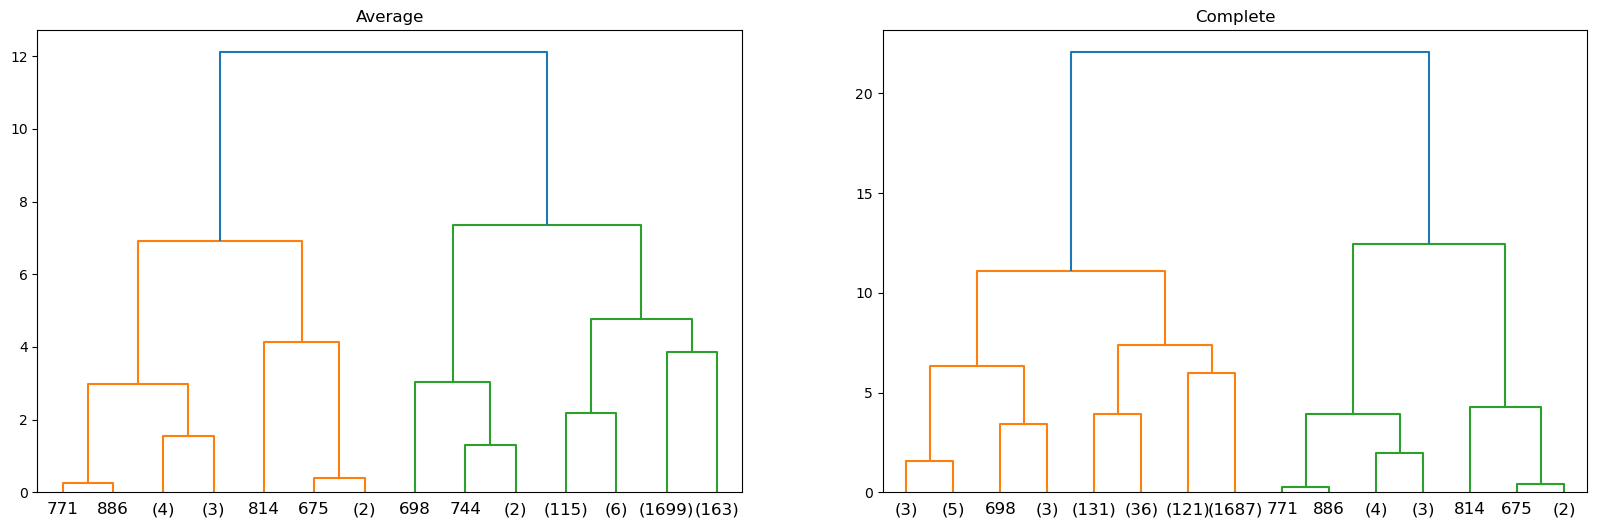

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
link_avg = linkage(data_scaled, method='average')
avg_dend = dendrogram(link_avg, ax=axes[0], truncate_mode='level', p=3)
axes[0].set_title('Average')

link_cmplt = linkage(data_scaled, method='complete')
cmplt_dend = dendrogram(link_cmplt, ax=axes[1], truncate_mode='level', p=3)
axes[1].set_title('Complete')

The left side of average (orange) is identical to the right side of complete (green). The other sides are pretty similar looking as well, although the numbers are a bit different. 

### Part 3: _k_-means clustering

 - Perform _k_-means clustering on the data. Use 4 clusters.
 - Evaluate the clustering performance using silhouette score.
 - Experiment with some other numbers of clusters. Does the data fit better into a different number of clusters according to silhouette score?

In [89]:
for i in range(3, 20):
    kmeans_data = KMeans(n_clusters=i).fit(data_scaled)
    shlt_score = silhouette_score(X=data_scaled, labels=kmeans_data.labels_)
    print('Silhoutte score for cluster size ', i, ':', shlt_score)

Silhoutte score for cluster size  3 : 0.5419542961641921
Silhoutte score for cluster size  4 : 0.6340409774707709
Silhoutte score for cluster size  5 : 0.7303901495638329
Silhoutte score for cluster size  6 : 0.7547927328732176
Silhoutte score for cluster size  7 : 0.772755305153354
Silhoutte score for cluster size  8 : 0.7870033283225591
Silhoutte score for cluster size  9 : 0.7479089046587858
Silhoutte score for cluster size  10 : 0.7702171564694363
Silhoutte score for cluster size  11 : 0.7594482224428938
Silhoutte score for cluster size  12 : 0.7453435736908213
Silhoutte score for cluster size  13 : 0.7677473230624086
Silhoutte score for cluster size  14 : 0.784832194236812
Silhoutte score for cluster size  15 : 0.7759957371818413
Silhoutte score for cluster size  16 : 0.7878001106605685
Silhoutte score for cluster size  17 : 0.8013663524897263
Silhoutte score for cluster size  18 : 0.7764022554827151
Silhoutte score for cluster size  19 : 0.7954167700279904


In [90]:
kmeans_data = KMeans(n_clusters=50).fit(data_scaled)
shlt_score = silhouette_score(X=data_scaled, labels=kmeans_data.labels_)
print('Silhoutte score for cluster size ', 50, ':', shlt_score)

Silhoutte score for cluster size  50 : 0.8058533393875568


Bigger cluster size seems to lead to a better score up to a point. Cluster size of 15 seems to be enough.

#### Rand score briefly described

Rand score is a measure of similarity between two partitions of a set of elements - in this case true classes and clusters found by the clustering algorithm - and it is one of the most frequently used performance metrics for clustering. It is computed by considering each pair of elements in the dataset and counting pairs of elements as follows:
 
         a: number of pairs such that the elements are in the same class and in the same cluster
         b: number of pairs such that the elements are in different classes and in different clusters
         c: number of pairs such that the elements are in the same class but in different clusters
         d: number of pairs such that the elements are in different classes but in the same cluster
     
     Given a, b, c, d, the formula for rand index is:
     
         rand_index = (a+b)/(a+b+c+d).
     
"Adjusted Rand index" is corrected for chance by using maximum and expected values of Rand index.

        adj_rand_index = (rand_index - expected_rand_index) / (max_rand_index - expected_rand_index)

###  Part 4a: Compare the clusters with the true labels (hierarchical clustering)
 
 - Cluster the data into 4 clusters using agglomerative hierarchical clustering.
 - Choose the linkage criterion that had the best silhouette score performance in Part 2a.
 - Visualize the data again using PCA, this time coloring the scatter plot based on the true class labels. Visually compare the two scatter plots: how well do the clusters found by the clustering algorithm match the true classes? Place the two scatter plots so that they can easily be compared (e.g. in subplots next to each other in the same figure).
 - For an objective evaluation of the clustering, compute the adjusted Rand score (use the scikit-learn implementation) using the true labels and the labels predicted by clustering algorithm. How do you interpret the result?
 - If the results seem unimpressive, don't get discouraged - clustering "real life" data sets to match classes is a difficult task, and a low Rand score does not necessarily mean that you have made a mistake.

Text(0, 0.5, 'PC2')

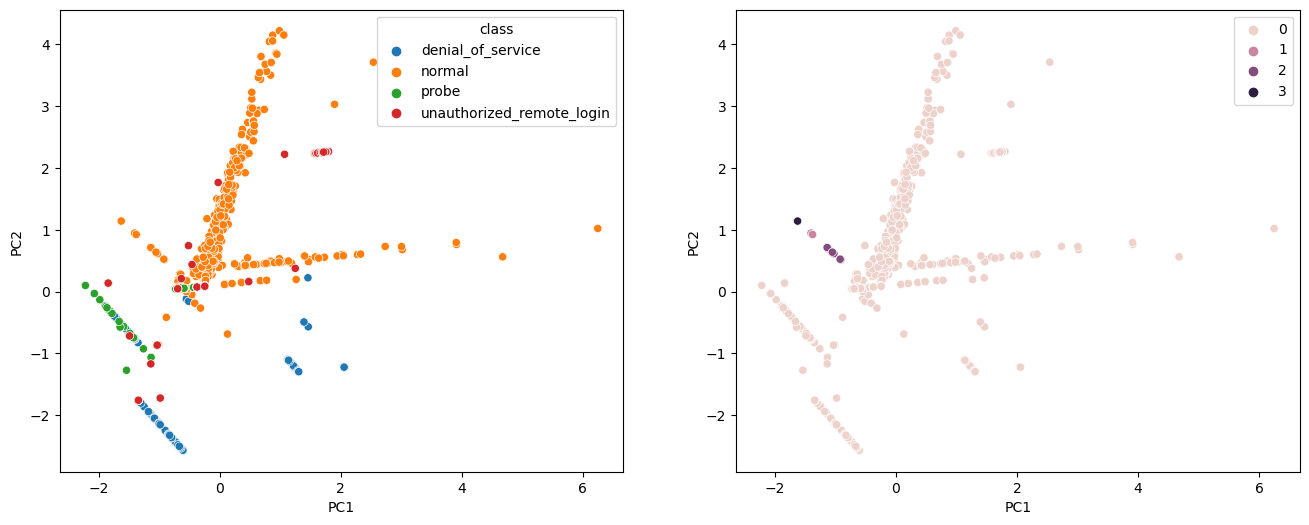

In [91]:
clusters_4a = AgglomerativeClustering(n_clusters=4, linkage='single').fit_predict(data_scaled)

fig_4a, axes_4a = plt.subplots(1, 2, figsize=(16, 6))
pca_4a = PCA(n_components=2)
data_pca_4a = pca.fit_transform(data_scaled)
pca_plot_4a = sns.scatterplot(x=data_pca_4a[:,0], y=data_pca_4a[:,1], ax=axes_4a[0], hue=data['class'])
pca_plot_4a.set_xlabel('PC1')
pca_plot_4a.set_ylabel('PC2')

pca_plot_4a_cluster = sns.scatterplot(x=data_pca_4a[:,0], y=data_pca_4a[:,1], ax=axes_4a[1], hue=clusters_4a)
pca_plot_4a_cluster.set_xlabel('PC1')
pca_plot_4a_cluster.set_ylabel('PC2')

In [92]:
# Calculate rand score

adjusted_rand_score(data['class'], clusters_4a)

0.00011807828578910034

This is not a succesful clustering. From scikit-learn docs: *Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.*

### Part 4b: Compare the clusters with true labels (_k_-means clustering)

 - Repeat the above steps, but this time using _k_-means clustering instead of hierarchical clustering.
 - Which performs better according to the adjusted Rand score?

Text(0, 0.5, 'PC2')

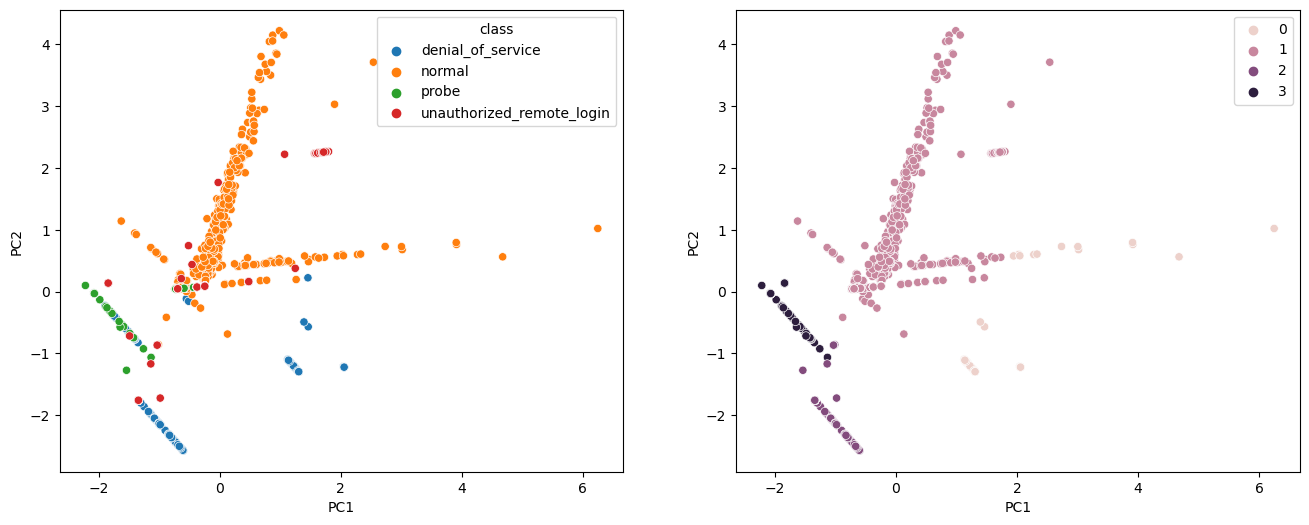

In [93]:
clusters_4b = KMeans(n_clusters=4).fit_predict(data_scaled)

fig_4b, axes_4b = plt.subplots(1, 2, figsize=(16, 6))
pca_4b = PCA(n_components=2)
data_pca_4b = pca.fit_transform(data_scaled)
pca_plot_4b = sns.scatterplot(x=data_pca_4b[:,0], y=data_pca_4b[:,1], ax=axes_4b[0], hue=data['class'])
pca_plot_4b.set_xlabel('PC1')
pca_plot_4b.set_ylabel('PC2')

pca_plot_4b_cluster = sns.scatterplot(x=data_pca_4b[:,0], y=data_pca_4b[:,1], ax=axes_4b[1], hue=clusters_4b)
pca_plot_4b_cluster.set_xlabel('PC1')
pca_plot_4b_cluster.set_ylabel('PC2')

In [94]:
# Calculate rand score

adjusted_rand_score(data['class'], clusters_4b)

0.2951546107072655

Kmeans clustering worked a lot better. The Rand Index is better and the plot looks much better.

### Part 5 (optional BONUS task): Clustering unlabeled data

In this task, you are working with data where the classes are not available, given as `ex3_seeds_data_BONUS.csv` on Moodle. [The original data set](https://archive.ics.uci.edu/ml/datasets/seeds) is available for for those who are interested, but **use the slightly modified data on Moodle** instead.

In general this is a very challenging and open-ended type of task that requires in-depth domain knowledge for meaningful results. Note, however, that in this exercise you are **not required** to research the domain in question (e.g. properties of different varieties of wheat). You might need to search for more information related to clustering in order to complete this exercise.

Some of the questions are open-ended and have no correct answer. It's enough to clearly show that you thought about the questions.

 - As in Part 1, z-score standardize the data, project it to 2 dimensions using PCA and visualize the result in a scatter plot.
 - Does the scatter plot look like the data might have a clustered structure? How many clusters do you see?
 - Decide, based on what you've learned about silhouette score and Rand score, which performance metric you should use in this task. Justify your choice.
 - Get an objective evaluation of how many clusters the data most likely has by using your chosen performance metric. Try both _k_-means clustering and agglomerative hierarchical clustering with different linkage criterions and see which performs best.
 - Visualize (with color) the best-performing result in the PCA scatter plot you created earlier.